In [32]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform, color

from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks

import pickle

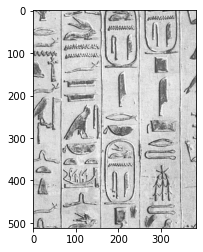

In [33]:
img=io.imread('test/0.jpg')
plt.imshow(img)

In [34]:
img.shape

(512, 384, 3)

In [35]:
detected=pd.read_json('test/image_0_predictions.txt')
coordinates=detected['bbox']

In [36]:
gray =cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [37]:
def crop_vertical(image):
    gray =cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges=canny(gray, sigma=3, low_threshold=10, high_threshold=50)
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
    h, theta, d = hough_line(edges, theta=tested_angles)
    _, angles, dist=hough_line_peaks(h, theta, d,25)
    dist= np.append(dist,[0,gray.shape[1]])
    sub_images=[]
    dist= sorted(dist)
    for i in range(len(dist)-1):
        sub_images.append(gray[:,int(dist[i]):int(dist[i+1])])
    return sub_images,dist

In [38]:
# edges=canny(gray, sigma=3, low_threshold=10, high_threshold=50)
# tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
# h, theta, d = hough_line(edges, theta=tested_angles)
# _, angles, dist=hough_line_peaks(h, theta, d,25)
# plt.imshow(edges)

In [81]:
def move_coord(coordinates,dist):
    new_coordinates=[]
    for d in range(len(dist)-1):
        new_coordinates.append([])

    for cor in coordinates:
        for i in range(len(dist)-1):
            if cor[0] >= dist[i] and cor[0] <= dist[i+1]:
                new_cor = cor.copy()
                new_cor[0]=new_cor[0]-dist[i]
                new_coordinates[i].append(new_cor)
    ordered_coor=[]
    for coor in new_coordinates:
        new_coordinates_df=pd.DataFrame(coor,columns=['X', 'Y','L','W'])
        new_coordinates_df=new_coordinates_df.sort_values(by=['Y','X'])
        ordered_coordinates=new_coordinates_df.to_numpy()
        ordered_coor.append(ordered_coordinates)
    return ordered_coor

In [82]:
# np.arange(5,9)

In [83]:
def get_glyphs(gray_image,coordinates):
    glyphs=[]
    for coordinate in coordinates:
        cor=np.asarray(coordinate).astype(int)
        glyph_img=gray_image[cor[1]:cor[1]+cor[3],cor[0]:cor[0]+cor[2]]
        glyphs.append(glyph_img)
    return glyphs

6


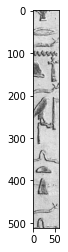

In [84]:
# split columns into seperated images and get the X values where the lines are
sub_images,dist=crop_vertical(img)
print(len(dist))
plt.imshow(sub_images[0],cmap='gray')

In [86]:
# move the coordinates into the seperated images
new_coordinates=move_coord(coordinates,dist)

In [87]:
# new_coordinates[1]
# ordered_full_coordinates

In [88]:
glyphs=[]
for i in range(len(sub_images)):
    glyphs.append(get_glyphs(sub_images[i],new_coordinates[i]))

In [89]:
# np.asarray(glyphs[0][0]).shape

In [90]:
def add_padding(img,new_shape=(75,50)):
#     img=np.asarray(img)
    h,w=img.shape
    exp_h,exp_w=new_shape
    addedh=0
    addedw=0
    
    if w <= exp_w and h <= exp_h:
        addedh = exp_h - h
        addedw = exp_w - w
    else:
        h0=h*exp_w
        w0=w*exp_h
        if h0 >= w0:
            addedw = (h0-w0)/exp_h
        else:
            addedh =(w0-h0)/exp_w
    
    addedh=int(addedh/2)
    addedw = int(addedw/2)
    
    bordered=cv2.copyMakeBorder(img,addedh,addedh,addedw,addedw,cv2.BORDER_REPLICATE)
#     bordered=cv2.copyMakeBorder(img,addedh,addedh,addedw,addedw,cv2.BORDER_CONSTANT, None, value = 255)
    bordered = cv2.GaussianBlur(bordered,(15,15),0)
    bordered[addedh:addedh+h, addedw:addedw+w] = img
#     bordered =cv2.GaussianBlur(bordered,(3,3),0)
    resized = cv2.resize(bordered, (exp_w,exp_h))
    return resized

padded= add_padding(glyphs[1][1])

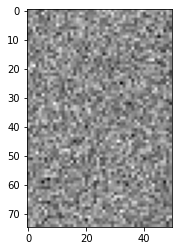

In [91]:
mean = 0
var = 0.1
sigma = var**0.5
noise = np.random.normal(mean,sigma,(75,50))

plt.imshow(noise,cmap='gray')

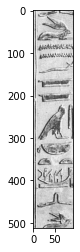

In [92]:
plt.imshow(sub_images[1],cmap='gray')

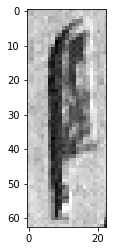

In [93]:
plt.imshow(glyphs[3][1],cmap='gray')

In [53]:

# from skimage import measure
# # Find contours at a constant value of 0.8
# r=glyphs[1][15]
# contours = measure.find_contours(r,0.1)

# # Display the image and plot all contours found
# fig, ax = plt.subplots()
# ax.imshow(r, cmap=plt.cm.gray)

# for contour in contours:
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

# ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])
# plt.show()

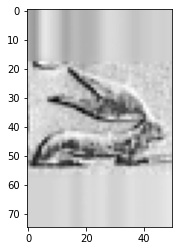

In [74]:
plt.imshow(padded,cmap='gray')

In [75]:
def pad_images(sentence_images):
    padded_images=[]
    for img in sentence_images:
        padded_images.append(add_padding(img))
    return padded_images
        

In [76]:
# glyphs[0][0].shape
sentence_padded = pad_images(glyphs[0])
sentence_padded[0].shape

(75, 50)

# Model prediction

In [77]:
with open("fine_tuned_model.pickle", "rb") as f:
    (model) = pickle.load(f)

In [78]:
with open("multi_anchor.pickle", "rb") as f:
    (multi_anchor_img,multi_anchor_label) = pickle.load(f)

In [80]:
import dill as pickle
with open("language_model_sent.pkl", "rb") as f:
    language_model = pickle.load(f)

AttributeError: Can't get attribute '_create_code' on <module 'dill._dill' from '/home/asmaa/anaconda3/lib/python3.7/site-packages/dill/_dill.py'>

In [ ]:
from sklearn.utils import shuffle
from collections import Counter, defaultdict

def lm_next(model,prev):
    pred = dict( eval('model'+ str(prev)))
    next_scores = sorted(pred.items(), key=lambda item: item[1],reverse=True)
    out = dict(next_scores)
    if len(list(out.keys()))==0:
        out ={'None':0}
    return out

def whichGlyph_pair(image,anchor_img,anchor_label):
    N,w,h,_=anchor_img.shape
#     pairs=[np.zeros((N, w, h,1)) for i in range(2)]
#     image=np.asarray(image)
    test_image= np.asarray([image]*N).reshape(N, w, h,1)
    
    anchor_label, test_image, anchor_img = shuffle(anchor_label, test_image, anchor_img)
#     pairs = [test_image,anchor_img]
    
    return test_image, anchor_img, anchor_label


def whichGlyph(model,image,anchor_img,anchor_label):
    test_image,anchor_img,targets = whichGlyph_pair(image,anchor_img,anchor_label)
    probs = model.predict([test_image,anchor_img])
    return probs,anchor_img,targets

def predict_multi_anchor(image,multi_anchor_img,multi_anchor_label,model):
    multi_N=multi_anchor_img.shape[0]
    final_scores=np.zeros((multi_anchor_label[0].shape[0],1))
    for j in range(multi_N):
      predicted,anchor_imgs,targets=whichGlyph(model,image,multi_anchor_img[j],multi_anchor_label[j])
      zipped_lists = zip(targets,predicted)
      sorted_pairs = sorted(zipped_lists)
      tuples = zip(*sorted_pairs)
      targets,predicted = [ list(tuple) for tuple in  tuples]
      final_scores = np.asarray(final_scores) + np.asarray(predicted)
    return final_scores,np.asarray(targets)
def choose_next(clf_3,score_3,language_model,prev):
    freq=lm_next(language_model,prev)
    freq_3=[]
    for pred in clf_3:
        if pred in freq.keys():
            freq_3.append(freq[pred])
        else:
            freq_3.append(0)
    freq_3=np.array(freq_3)
    score_3 =np.array(score_3).flatten()
    score_3_sum = score_3 / np.sum(score_3)
    freq_3_exp = np.exp(freq_3)/sum(np.exp(freq_3))
    scores = score_3_sum + 2*freq_3_exp
    predicted=clf_3[np.argmax(scores)]
    return predicted

def predict_lm(Xtest,multi_anchor_img,multi_anchor_label,model,language_model):
    preds=[]
    for new in Xtest:
        if len(preds) < 2 :
            predicted,targets=predict_multi_anchor(new,multi_anchor_img,multi_anchor_label,model)
            sort_index = np.argsort(np.asarray(predicted).reshape(len(predicted),))
            targ=targets[sort_index[-1]]
#             print(targ)
            if targ =='UNKNOWN':
                targ=targets[sort_index[-2]] 
            preds.append(targ)
        else:
            predicted,targets=predict_multi_anchor(new,multi_anchor_img,multi_anchor_label,model)
            sort_index = np.argsort(np.asarray(predicted).reshape(len(predicted),))
            predicted = choose_next(targets[sort_index[-3:]],predicted[sort_index[-3:]],language_model,preds[-2:])
            preds.append(predicted)
    return preds

In [29]:
len(sentence_padded)

15

## predict all sentence

In [30]:
import time
t_start = time.time()

preds=predict_lm(sentence_padded,multi_anchor_img,multi_anchor_label,model,language_model)

print(f" {len(sentence_padded)} glyph took {(time.time()-t_start)} sec")


 15 glyph took 26.164337635040283 sec


In [31]:
"".join(preds)

'G40D21I9N35Aa27N29I9M17M44R8F4X1Q3D39V31'

### predict a random image

In [33]:
# test_image=glyphs[1][1]
# padded= add_padding(test_image,(75,50))

# predicted,anchor_imgs,targets=whichGlyph(model,padded,anchor_img,anchor_label)

# maxp = np.argmax(predicted)
# print(targets[maxp])
# f, ax = plt.subplots(1,2)
# ax[0].imshow(anchor_imgs[maxp].reshape(75,50),cmap='gray')
# ax[0].set_title('predicted')
# ax[1].imshow(padded.reshape(75,50),cmap='gray')
# ax[1].set_title('actual');

In [31]:
def predict_all(glyphs,model,multi_anchor_img,multi_anchor_label,language_model):
    predictions=[]
    for glyph_list in glyphs:
        
        sentence_padded = pad_images(glyph_list)
        preds=predict_lm(sentence_padded,multi_anchor_img,multi_anchor_label,model,language_model)
        pred_sub="".join(preds)
#         for glyph in glyph_list:
#             padded= add_padding(glyph,(75,50))
#             predicted,anchor_imgs,targets=whichGlyph(model,padded,anchor_img,anchor_label)
#             maxp = np.argmax(predicted)
#             pred_sub+=targets[maxp]
        predictions.append(pred_sub)
    return predictions

In [79]:
# preds=predict_all(glyphs,model,anchor_img,anchor_label,coordinates)
# predict_all(glyphs,model,multi_anchor_img,multi_anchor_label,language_model,coordinates)
# np.asarray(preds)

In [124]:
def image_to_gardiner(img,coordinates,multi_anchor_img,multi_anchor_label,model,language_model):
    
    sub_images,dist=crop_vertical(img)
    
    new_coordinates=move_coord(coordinates,dist)
    
    glyphs=[]
    for i in range(len(sub_images)):
        glyphs.append(get_glyphs(sub_images[i],new_coordinates[i]))
    
    preds=predict_all(glyphs,model,multi_anchor_img,multi_anchor_label,language_model)
    
    return preds

In [125]:
test_img=io.imread('test/0.jpg')
detected=pd.read_json('test/image_0_predictions.txt')
coordinates=detected['bbox']
t_start = time.time()
preds,final_coor=image_to_gardiner(test_img,coordinates,multi_anchor_img,multi_anchor_label,model,language_model)
print(f" fun took {(time.time()-t_start)} sec")

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
4 0
4 1
4 2
4 3
 fun took 129.97009587287903 sec


In [123]:
# plt.imshow(test_img)
# preds[0]
# final_coor

[[{'coor': array([ 0.        ,  0.33884522, 45.86231995, 29.02653885,  0.        ]),
   'pred': ['G40']},
  {'coor': array([ 0.        , 36.54957199, 57.02404022, 27.63505936,  1.        ]),
   'pred': ['D21']},
  {'coor': array([ 0.32528687, 62.30329132, 60.91191483, 28.91757202,  2.        ]),
   'pred': ['I9']},
  {'coor': array([ 0.09587585, 92.00092316, 59.62917328, 21.58892059,  3.        ]),
   'pred': ['N35']},
  {'coor': array([ 32.81533432, 114.92093658,  28.66400146,  56.48886871,
            4.        ]),
   'pred': ['Aa27']},
  {'coor': array([  0.        , 115.38690948,  33.34875107,  50.11475372,
            5.        ]),
   'pred': ['N29']},
  {'coor': array([1.18146971e-01, 1.69002609e+02, 6.17148666e+01, 3.28655090e+01,
          6.00000000e+00]),
   'pred': ['I9']},
  {'coor': array([  0.29201841, 201.96313477,  42.81097031, 110.53994751,
            7.        ]),
   'pred': ['M17']},
  {'coor': array([ 41.27460861, 202.35493469,  22.74489212,  84.01365662,
         

In [116]:
print(len(pred_arr[0]))
print(len(ordered_full_coordinates[0]))


15
15
